In [1]:
from ib.ext.Contract import Contract
from ib.ext.ScannerSubscription import ScannerSubscription
from ib.ext.ContractDetails import ContractDetails
from ib.ext.Order import Order
from ib.opt import Connection, message

from time import sleep 
from datetime import datetime
from ibapi.ticktype import TickTypeEnum
import talib

In [2]:
from bs4 import BeautifulSoup
import requests
import re
from pprint import pprint
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
r = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = BeautifulSoup(r.text,'html.parser')
T=[]
tickers = soup.find_all('a',{'class':'external text'},{'rel':'nofollow'})
for i in tickers[:-180]:
    if i.text == 'reports':
        del i
    else:
        T.append(i.text)
sp500 = T[:-11]

In [4]:
def demean(df):
    
    df_demean = pd.DataFrame()
    for date in df.index:
        for tick in df.columns:
            df_demean.loc[date,tick] = df.loc[date,tick] - df.loc[date,:].mean()
    return df_demean

def zscore(df):
    
    df_zscore = pd.DataFrame()
    for date in df.index:
        for tick in df.columns:
            df_zscore.loc[date,tick] = (df.loc[date,tick] - df.loc[date,:].mean())/df.loc[date,:].std(ddof=0)
    return df_zscore

In [5]:
def error_handler(msg):
    """Handles the capturing of error messages"""
    print ("Server Error: {}".format(msg))

def reply_handler(msg):
    """Handles of server replies"""
    print ("Server Response: {}, {}".format(msg.typeName, msg))

def next_id(msg):
    global order_id
    order_id = int(re.findall('\d+', str(msg))[0])
    
    return order_id
    
def historical_data_handler(msg):  
    global historical_data
    
    if ('finished' in str(msg.date)) == False:   
        
        historical_data.loc[len(historical_data)] = ([msg.date, msg.open, msg.high, 
                                                      msg.low, msg.close, msg.volume])
    else:  
        historical_data.set_index('Date',inplace=True)

        
def ReportsFinStatements(msg):
    global annual
    global quarter
   
    parser = BeautifulSoup(msg.data, 'lxml')

    mapp = dict()
    for item in parser.findAll('mapitem'):
        mapp[item['coaitem']] = item.text
        
    
    #ANNUAL
    index = [];columns = []
    for item in parser.findAll('annualperiods')[0].findAll('fiscalperiod'):
        index.append(datetime.strptime(item['fiscalyear'], '%Y').year)
    
    for i in parser.findAll('annualperiods')[0].findAll('fiscalperiod')[0].findAll('lineitem'):
        columns.append(mapp[i['coacode']])

    annual = pd.DataFrame(index = index, columns = columns)
    annual.index.name = 'Annual'
    for item in parser.findAll('annualperiods')[0].findAll('fiscalperiod'):
        for i in item.findAll('lineitem'):
            try:
                annual.loc[datetime.strptime(item['fiscalyear'], '%Y').year,mapp[i['coacode']]] = float(i.text)
            except:
                annual.loc[datetime.strptime(item['fiscalyear'], '%Y').year,mapp[i['coacode']]] = np.nan
        
    # QUARTER
    index_q = [];columns_q = []
    for item in parser.findAll('interimperiods')[0].findAll('fiscalperiod'):
        index_q.append(datetime.strptime(item['enddate'], '%Y-%m-%d').date())
    
    for i in parser.findAll('interimperiods')[0].findAll('fiscalperiod')[0].findAll('lineitem'):
        columns_q.append(mapp[i['coacode']])

    quarter = pd.DataFrame(index = index_q, columns = columns_q)
    quarter.index.name = 'Quarter'
    for item in parser.findAll('interimperiods')[0].findAll('fiscalperiod'):
        for i in item.findAll('lineitem'):
            try:
                quarter.loc[datetime.strptime(item['enddate'], '%Y-%m-%d').date(),mapp[i['coacode']]] = float(i.text)
            except:
                quarter.loc[datetime.strptime(item['enddate'], '%Y-%m-%d').date(),mapp[i['coacode']]] = np.nan


def position_account(msg):
    global account
    account = msg

def Scanner(msg):
    global symbol
    global sectype
    global exchange
    global currency
        
    symbol.append(msg.contractDetails.m_summary.m_symbol)
    sectype.append(msg.contractDetails.m_summary.m_secType)
    exchange.append(msg.contractDetails.m_summary.m_exchange)
    currency.append(msg.contractDetails.m_summary.m_currency)

def Analyst_Estimates(msg):
    global resc
    global resc_ann
    global resc_q
    
    parser = BeautifulSoup(msg.data, 'lxml')
    resc.iloc[:,0] = parser.find('name').text    
    resc.iloc[:,1] = parser.find('exchange').text
    resc.iloc[:,2] = parser.findAll('secid')[0].text
    resc.iloc[:,3] = parser.findAll('sector')[0].text

    resc.iloc[:,4] = parser.findAll('marketdataitem')[0].text
    resc.iloc[:,5] = parser.findAll('marketdataitem')[1].text
    resc.iloc[:,6] = parser.findAll('marketdataitem')[2].text
    resc.iloc[:,7] = parser.findAll('marketdataitem')[3].text
    resc.iloc[:,8] = parser.findAll('marketdataitem')[4].text
    resc.iloc[:,9] = parser.findAll('fyactual')[0].text
    
    annual = [];columns = [];quarter = []
    for item in parser.findAll('fyactual'):
        columns.append(item['type'])
        for per in item.findAll('fyperiod'):
            if per['periodtype'] == 'A':
                annual.append(per['fyear'])
            if per['periodtype'] == 'Q':
                quarter.append('{}-{}'.format(per['endcalyear'],per['endmonth']))
    
    index = list(set(annual))
    index_q = list(set(quarter))
    resc_ann = pd.DataFrame(index = index, columns = columns).sort_index(axis = 0,ascending = False)
    resc_q = pd.DataFrame(index = index_q, columns = columns).sort_index(axis = 0,ascending = False)
    
    for item in parser.findAll('fyactual'):
        for per in item.findAll('fyperiod'):
            
            if per['periodtype'] == 'Q':
                try:
                    resc_q.loc['{}-{}'.format(per['endcalyear'],per['endmonth']),item['type']] = float(per.find('actvalue').text)
                except:
                    resc_q.loc['{}-{}'.format(per['endcalyear'],per['endmonth']),item['type']] = np.nan  
                    
            if per['periodtype'] == 'A':
                try:
                    resc_ann.loc[per['fyear'],item['type']] = float(per.find('actvalue').text)
                except:
                    resc_ann.loc[per['fyear'],item['type']] = np.nan

                    
def ReportsFinSummary(msg):
    global fin
    
    parser = BeautifulSoup(msg.data, 'lxml')
    date_div = [];data_div = []
    
    for i in parser.findAll('dividendpershare'):
        if i['period'] == '12M' and i['reporttype'] == 'TTM':
            
            date_div.append(i['asofdate'])
            try:
                data_div.append(float(i.text))
            except:
                data_div.append(np.nan)
                
    data_rev = []
    for i in parser.findAll('totalrevenue'):
        if i['period'] == '12M' and i['reporttype'] == 'TTM':
            try:
                data_rev.append(float(i.text))
            except:
                data_rev.append(np.nan)
                
    data_eps = []
    for i in parser.findAll('eps'):
        if i['period'] == '12M' and i['reporttype'] == 'TTM':
            try:
                data_eps.append(float(i.text))
            except:
                data_eps.append(np.nan)

    fin = pd.DataFrame(index = date_div,
                       data = {'Dividend Per Share(TTM)':data_div,
                               'Total Revenue(TTM)':data_rev, 
                               'EPS(TTM)':data_eps}).sort_index(axis = 0,ascending = False)

def ReportSnapshot(msg):
    global business_summary
    global brief
    global snap
    global address
    global ratio
    global estimate
    
    parser = BeautifulSoup(msg.data, 'lxml')
    
    business_summary = parser.findAll('text')[0].text
    brief = parser.findAll('text')[1].text
    address = '{},{},{},{}'.format(parser.find('contactinfo').find('streetaddress').text,
                                   parser.find('contactinfo').find('city').text,
                                   parser.find('contactinfo').find('state-region').text,
                                   parser.find('contactinfo').find('country').text)
    
    snap = pd.DataFrame(index = [parser.findAll('coid')[1].text],
                        data = {'Company Type': parser.find('cotype').text,
                                'Desc':parser.findAll('issue')[0]['desc'],
                                'Exchange': parser.findAll('exchange')[0].text,
                                'Industry':parser.findAll('industry')[0].text,
                                'Index':parser.find('indexconstituet').text})
    dicted = {};dicted_est = {}
    for i in range(len(parser.find('ratios').findAll('ratio'))):
        try:
            dicted[parser.find('ratios').findAll('ratio')[i]['fieldname']] = float(parser.find('ratios').findAll('ratio')[i].text)
        except:
            dicted[parser.find('ratios').findAll('ratio')[i]['fieldname']] = parser.find('ratios').findAll('ratio')[i].text
            
    ratio = pd.DataFrame(index = [parser.findAll('coid')[1].text], data = dicted)
    
    for i in range(len(parser.find('forecastdata').findAll('ratio'))):
        try:
            dicted_est[parser.find('forecastdata').findAll('ratio')[i]['fieldname']] = float(parser.find('forecastdata').findAll('ratio')[i].text)
        except:
            dicted_est[parser.find('forecastdata').findAll('ratio')[i]['fieldname']] = parser.find('forecastdata').findAll('ratio')[i].text
            
    estimate = pd.DataFrame(index = [parser.findAll('coid')[1].text], data = dicted_est)
    
def create_contract(symbol, sec_type, exch, prim_exch, curr):

    contract = Contract()
    contract.m_symbol = symbol
    contract.m_secType = sec_type
    contract.m_exchange = exch
    contract.m_primaryExch = prim_exch
    contract.m_currency = curr
    
    return contract

def create_order(order_type, quantity, action):

    order = Order()
    order.m_orderType = order_type
    order.m_totalQuantity = quantity
    order.m_action = action
    
    return order

def create_scanner(numberOfRows, instrument, locationCode, ScanCode, 
                   AbovePrice, marketCapAbove, AboveVolume):

    scanSub = ScannerSubscription()
    scanSub.numberOfRows(numberOfRows)
    scanSub.m_instrument = instrument
    scanSub.m_locationCode = locationCode
    scanSub.m_scanCode = ScanCode
    scanSub.m_abovePrice = AbovePrice
    scanSub.m_marketCapAbove = marketCapAbove
    scanSub.m_aboveVolume = AboveVolume
    
    return scanSub



# Connecting to TWS

In [6]:
tws_conn = Connection.create(host='127.0.0.1',port=7497, clientId=0)
tws_conn.connect()

Server Version: 76
TWS Time at connection:20191023 10:08:15 EST


True

In [7]:
tws_conn.register(error_handler, 'Error')
tws_conn.register(reply_handler)
sleep(5)
#tws_conn.unregister(error_handler, 'Error')
#tws_conn.unregister(reply_handler)

Server Error: <error id=-1, errorCode=2104, errorMsg=Market data farm connection is OK:eufarm>
Server Error: <error id=-1, errorCode=2104, errorMsg=Market data farm connection is OK:cashfarm>
Server Error: <error id=-1, errorCode=2104, errorMsg=Market data farm connection is OK:usfarm>
Server Error: <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:euhmds>
Server Error: <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:fundfarm>
Server Error: <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
Server Error: <error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefnj>


In [8]:
contracts = []
for stock in sp500:
    try:
        contract = create_contract(symbol = stock,
                                   sec_type = 'STK',
                                    exch = 'SMART',
                                   prim_exch = 'NASDAQ',
                                    curr = 'USD')
        contracts.append(contract)
    except:
        continue

In [9]:
contracts

## Technical Data

In [10]:
Period = '1 Y'
Frequency = '1 day'

In [11]:
historical_data = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

In [12]:
tws_conn.register(historical_data_handler, message.historicalData)
tws_conn.reqHistoricalData(5, contracts[10],'', Period, Frequency,'TRADES',1,1)
sleep(5)
tws_conn.unregister(historical_data_handler, message.historicalData)

True

In [14]:
print (historical_data.tail())

           Open   High    Low  Close Volume
Date                                       
20191017  76.10  76.54  74.61  74.70   3305
20191018  74.64  75.28  74.44  74.58   3790
20191021  75.40  76.64  75.23  75.47   3963
20191022  75.39  76.96  74.66  75.62   3202
20191023  75.23  76.27  75.23  75.70    283


In [14]:
universe = sp500[:10]

In [15]:
price = pd.DataFrame(index = historical_data.index,data = [], columns = universe)
revenue = pd.DataFrame(index = historical_data.index , columns = universe)
net_income = pd.DataFrame(index = historical_data.index , columns = universe)
total_debt = pd.DataFrame(index = historical_data.index , columns = universe)
total_common = pd.DataFrame(index = historical_data.index , columns = universe)
deps = pd.DataFrame(index = historical_data.index , columns = universe)
rd = pd.DataFrame(index = historical_data.index , columns = universe)
sector = pd.DataFrame(index = historical_data.index , columns = universe)
exchange = pd.DataFrame(index = historical_data.index , columns = universe)
name = pd.DataFrame(index = historical_data.index , columns = universe)

for i,tick in enumerate(universe):
    historical_data = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    resc = pd.DataFrame(index = [0],columns = ['Name', 'Exchange', 'Symbol', 'Sector', 'CLPRICE', 
                                               'SHARESOUT','MARKETCAP', '52WKHIGH', '52WKLOW','NAV'])    
    resc_ann = pd.DataFrame();resc_q = pd.DataFrame();annual = pd.DataFrame();quarter = pd.DataFrame()
    
    tws_conn.register(Analyst_Estimates, message.fundamentalData)
    tws_conn.register(ReportsFinStatements, message.fundamentalData)
    tws_conn.register(historical_data_handler, message.historicalData)
    
    tws_conn.reqFundamentalData(i,contract=contracts[i],reportType='RESC')
    sleep(5)
    tws_conn.reqHistoricalData(i, contracts[i],'', Period, Frequency,'TRADES',1,1)
    sleep(5)
    tws_conn.reqFundamentalData(i,contract=contracts[i],reportType='ReportsFinStatements')
    sleep(5)
    
    tws_conn.unregister(ReportsFinStatements, message.fundamentalData)
    tws_conn.unregister(historical_data_handler, message.historicalData)
    tws_conn.unregister(Analyst_Estimates, message.fundamentalData)    
    
    price[tick] = historical_data['Close']

        
    for date in historical_data.index:
            
        try:
            sector.loc[date,tick] = resc['Sector'][0]
            exchange.loc[date,tick] = resc['Exchange'][0]
            name.loc[date,tick] = resc['Name'][0]
               
        except:
            sector.loc[date,tick] = np.nan
            exchange.loc[date,tick] = np.nan
            name.loc[date,tick] = np.nan
      
        try:
            
            if int(datetime.strptime(str(date), "%Y%m%d").timestamp()) >= int(datetime.strptime(str(quarter.index[0]), '%Y-%m-%d').timestamp()):
                revenue.loc[date,tick] = quarter.loc[quarter.index[0],'Revenue']
                net_income.loc[date,tick] = quarter.loc[quarter.index[0],'Net Income']
                total_debt.loc[date,tick] = quarter.loc[quarter.index[0],'Total Debt']
                total_common.loc[date,tick] = quarter.loc[quarter.index[0],'Total Common Shares Outstanding']
                deps.loc[date,tick] = quarter.loc[quarter.index[0], 'Diluted Normalized EPS']
                rd.loc[date,tick] = quarter.loc[quarter.index[0], 'Research & Development']                  
                                 
            elif int(datetime.strptime(str(date), "%Y%m%d").timestamp()) < int(datetime.strptime(str(quarter.index[0]), '%Y-%m-%d').timestamp()) and int(datetime.strptime(str(date), "%Y%m%d").timestamp()) >= int(datetime.strptime(str(quarter.index[1]), '%Y-%m-%d').timestamp()):
                revenue.loc[date,tick] = quarter.loc[quarter.index[1],'Revenue']
                net_income.loc[date,tick] = quarter.loc[quarter.index[1],'Net Income']
                total_debt.loc[date,tick] = quarter.loc[quarter.index[1],'Total Debt']
                total_common.loc[date,tick] = quarter.loc[quarter.index[1],'Total Common Shares Outstanding']
                deps.loc[date,tick] = quarter.loc[quarter.index[1], 'Diluted Normalized EPS']
                rd.loc[date,tick] = quarter.loc[quarter.index[1], 'Research & Development']          
           
            elif int(datetime.strptime(str(date), "%Y%m%d").timestamp()) < int(datetime.strptime(str(quarter.index[1]), '%Y-%m-%d').timestamp()) and int(datetime.strptime(str(date), "%Y%m%d").timestamp()) >= int(datetime.strptime(str(quarter.index[2]), '%Y-%m-%d').timestamp()):
                revenue.loc[date,tick] = quarter.loc[quarter.index[2],'Revenue']
                net_income.loc[date,tick] = quarter.loc[quarter.index[2],'Net Income']
                total_debt.loc[date,tick] = quarter.loc[quarter.index[2],'Total Debt']
                total_common.loc[date,tick] = quarter.loc[quarter.index[2],'Total Common Shares Outstanding']
                deps.loc[date,tick] = quarter.loc[quarter.index[2], 'Diluted Normalized EPS']
                rd.loc[date,tick] = quarter.loc[quarter.index[2], 'Research & Development']          
                                 
                    
            elif int(datetime.strptime(str(date), "%Y%m%d").timestamp()) < int(datetime.strptime(str(quarter.index[2]), '%Y-%m-%d').timestamp()) and int(datetime.strptime(str(date), "%Y%m%d").timestamp()) >= int(datetime.strptime(str(quarter.index[3]), '%Y-%m-%d').timestamp()):
                revenue.loc[date,tick] = quarter.loc[quarter.index[3],'Revenue']
                net_income.loc[date,tick] = quarter.loc[quarter.index[3],'Net Income']
                total_debt.loc[date,tick] = quarter.loc[quarter.index[3],'Total Debt']
                total_common.loc[date,tick] = quarter.loc[quarter.index[3],'Total Common Shares Outstanding']
                deps.loc[date,tick] = quarter.loc[quarter.index[3], 'Diluted Normalized EPS']          
                rd.loc[date,tick] = quarter.loc[quarter.index[3], 'Research & Development']          
                
        except:
            revenue.loc[date,tick] = np.nan
            net_income.loc[date,tick] = np.nan
            total_debt.loc[date,tick] = np.nan
            total_common.loc[date,tick] = np.nan
            deps.loc[date,tick] = np.nan
            rd.loc[date,tick] = np.nan   
        
    

20-Oct-19 10:46:14 ERROR     Exception in message dispatch.  Handler 'ReportsFinStatements' for 'fundamentalData'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ib/opt/dispatcher.py", line 44, in __call__
    results.append(listener(message))
  File "<ipython-input-5-10c58da8d871>", line 39, in ReportsFinStatements
    for item in parser.findAll('annualperiods')[0].findAll('fiscalperiod'):
IndexError: list index out of range
20-Oct-19 10:46:20 ERROR     Exception in message dispatch.  Handler 'Analyst_Estimates' for 'fundamentalData'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ib/opt/dispatcher.py", line 44, in __call__
    results.append(listener(message))
  File "<ipython-input-5-10c58da8d871>", line 93, in Analyst_Estimates
    resc.iloc[:,0] = parser.find('name').text
AttributeError: 'NoneType' object has no attribute 'text'
20-Oct-19 10:46:29 ERROR     Exception in message dispatch.  Handler 'ReportsFinStatem

20-Oct-19 10:48:35 ERROR     Exception in message dispatch.  Handler 'ReportsFinStatements' for 'fundamentalData'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ib/opt/dispatcher.py", line 44, in __call__
    results.append(listener(message))
  File "<ipython-input-5-10c58da8d871>", line 39, in ReportsFinStatements
    for item in parser.findAll('annualperiods')[0].findAll('fiscalperiod'):
IndexError: list index out of range
20-Oct-19 10:48:42 ERROR     Exception in message dispatch.  Handler 'Analyst_Estimates' for 'fundamentalData'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ib/opt/dispatcher.py", line 44, in __call__
    results.append(listener(message))
  File "<ipython-input-5-10c58da8d871>", line 93, in Analyst_Estimates
    resc.iloc[:,0] = parser.find('name').text
AttributeError: 'NoneType' object has no attribute 'text'


In [16]:
PRICE = price.stack().to_frame('Price')
SECTOR = sector.stack().to_frame('Sector')
EXCHANGE = exchange.stack().to_frame('Exchange')
NAME = name.stack().to_frame('Name')
REVENUE = revenue.stack().to_frame('Revenue')
NET = net_income.stack().to_frame('Net Income')
DEBT = total_debt.stack().to_frame('Total Debt')
COM = total_common.stack().to_frame('Total Common Shares Outstanding')
DEPS = deps.stack().to_frame('Diluted Normalized EPS')
RD = rd.stack().to_frame('Research & Development')

In [17]:
df = pd.concat([PRICE,REVENUE,NET,DEBT,COM,DEPS,RD,SECTOR,NAME,EXCHANGE],axis=1)
df.index.levels[1].name = 'Symbol'

In [18]:
sector

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES
Date,,,,,,,,,,
20181019,Industrials,Healthcare,Healthcare,Healthcare,Industrials,Cyclical Consumer Goods & Services,Technology,Technology,Cyclical Consumer Goods & Services,Utilities
20181022,Industrials,Healthcare,Healthcare,Healthcare,Industrials,Cyclical Consumer Goods & Services,Technology,Technology,Cyclical Consumer Goods & Services,Utilities
20181023,Industrials,Healthcare,Healthcare,Healthcare,Industrials,Cyclical Consumer Goods & Services,Technology,Technology,Cyclical Consumer Goods & Services,Utilities
20181024,Industrials,Healthcare,Healthcare,Healthcare,Industrials,Cyclical Consumer Goods & Services,Technology,Technology,Cyclical Consumer Goods & Services,Utilities
20181025,Industrials,Healthcare,Healthcare,Healthcare,Industrials,Cyclical Consumer Goods & Services,Technology,Technology,Cyclical Consumer Goods & Services,Utilities
20181026,Industrials,Healthcare,Healthcare,Healthcare,Industrials,Cyclical Consumer Goods & Services,Technology,Technology,Cyclical Consumer Goods & Services,Utilities
20181029,Industrials,Healthcare,Healthcare,Healthcare,Industrials,Cyclical Consumer Goods & Services,Technology,Technology,Cyclical Consumer Goods & Services,Utilities
20181030,Industrials,Healthcare,Healthcare,Healthcare,Industrials,Cyclical Consumer Goods & Services,Technology,Technology,Cyclical Consumer Goods & Services,Utilities
20181031,Industrials,Healthcare,Healthcare,Healthcare,Industrials,Cyclical Consumer Goods & Services,Technology,Technology,Cyclical Consumer Goods & Services,Utilities


In [21]:
df.iloc[:,:-3]

Price  Revenue Net Income Total Debt  \
Date     Symbol                                          
20181019 AAP     164.33      NaN        NaN        NaN   
         ABBV     87.97     8236       2747      40508   
         ABMD    362.42  181.778     50.127          0   
         ABT      67.59     7656        563      23558   
         ACN     158.28      NaN        NaN        NaN   
         ADBE    245.03      NaN        NaN        NaN   
         AES      14.98      NaN        NaN        NaN   
         AMD      23.66     1653        102       1303   
         ATVI     69.75     1512        260       2670   
         MMM     199.85     8152       1543      14846   
20181022 AAP     164.77      NaN        NaN        NaN   
         ABBV     84.27     8236       2747      40508   
         ABMD    366.20  181.778     50.127          0   
         ABT      68.52     7656        563      23558   
         ACN     159.55      NaN        NaN        NaN   
         ADBE    251.06      NaN        NaN        NaN   
         AES      15.01      NaN        NaN        NaN   
         AMD      25.03     1653        102       1303   
         ATVI     69.78     1512        260       2670   
         MMM     201.36     8152       1543      14846   
20181023 AAP     163.97      NaN        NaN        NaN   
         ABBV     82.96     8236       2747      40508   
         ABMD    370.04  181.778     50.127          0   
         ABT      68.57     7656        563      23558   
         ACN     158.09      NaN        NaN        NaN   
         ADBE    251.76      NaN        NaN        NaN   
         AES      14.72      NaN        NaN        NaN   
         AMD      25.09     1653        102       1303   
         ATVI     68.98     1512        260       2670   
         MMM     192.55     8152       1543      14846   
...                 ...      ...        ...        ...   
20191016 AAP     162.75      NaN        NaN        NaN   
         ABBV     74.75     8255        741      37260   
         ABMD    178.67  207.666     88.923          0   
         ABT      81.78     7979       1006      19194   
         ACN     186.57      NaN        NaN        NaN   
         ADBE    272.70  2834.13    792.763    4137.02   
         AES      16.13      NaN        NaN        NaN   
         AMD      30.81     1531         35       1031   
         ATVI     55.59     1396        328       2673   
         MMM     162.18     8171       1127      15943   
20191017 AAP     163.75      NaN        NaN        NaN   
         ABBV     75.14     8255        741      37260   
         ABMD    176.52  207.666     88.923          0   
         ABT      82.38     7979       1006      19194   
         ACN     186.04      NaN        NaN        NaN   
         ADBE    269.24  2834.13    792.763    4137.02   
         AES      16.24      NaN        NaN        NaN   
         AMD      31.14     1531         35       1031   
         ATVI     55.59     1396        328       2673   
         MMM     163.54     8171       1127      15943   
20191018 AAP     163.50      NaN        NaN        NaN   
         ABBV     76.46     8255        741      37260   
         ABMD    175.30  207.666     88.923          0   
         ABT      82.79     7979       1006      19194   
         ACN     187.08      NaN        NaN        NaN   
         ADBE    265.52  2834.13    792.763    4137.02   
         AES      16.38      NaN        NaN        NaN   
         AMD      30.97     1531         35       1031   
         ATVI     54.54     1396        328       2673   
         MMM     163.10     8171       1127      15943   

                Total Common Shares Outstanding Diluted Normalized EPS  \
Date     Symbol                                                          
20181019 AAP                                NaN                    NaN   
         ABBV                           1504.16                1.84881   
         ABMD                           45.0384                 1.0

In [20]:
df.loc[('20181022','ADBE'),:]

Price                                  251.06
Revenue                                   NaN
Net Income                                NaN
Total Debt                                NaN
Total Common Shares Outstanding           NaN
Diluted Normalized EPS                    NaN
Research & Development                    NaN
Sector                             Technology
Name                                Adobe Inc
Exchange                               NASDAQ
Name: (20181022, ADBE), dtype: object

In [4]:
price = pd.read_csv('price.csv',index_col = 'Date')

In [19]:
datetime.strptime(str(price.index[0]), "%Y%m%d").date()

datetime.date(2017, 10, 19)

In [17]:
int(datetime.strptime(str(price.index[0]), "%Y%m%d").timestamp())

1508385600

In [24]:
returns  = price.apply(lambda x:(x - x.shift(1))/x).iloc[1:,:].fillna(0).iloc[1:,:]

In [25]:
returns.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES
Date,,,,,,,,,,
20171027,0.057170,-0.017157,-0.045361,0.035622,0.026452,0.023542,0.009530,-0.166385,-0.059197,-0.032468
20171030,0.040992,-0.032971,-0.039028,0.019389,0.027636,0.058806,0.021985,-0.294766,-0.047683,-0.036313
20171031,-0.019375,-0.021206,-0.015956,0.084024,0.024234,0.042144,0.020438,-0.297223,-0.030707,-0.033866
20171101,-0.032583,-0.027593,0.007248,0.092752,0.012591,0.053880,0.025078,-0.141667,-0.031703,-0.031220
20171102,-0.003057,-0.020416,0.016040,0.055038,0.010179,0.051795,0.039737,-0.106452,-0.048476,-0.006487


# Statistical Risk Model
It's time to build the risk model. You'll be creating a statistical risk model using PCA. So, the first thing is building the PCA model.
## Fit PCA
Implement `fit_pca` to fit a PCA model to the returns data

In [26]:
from sklearn.decomposition import PCA


def fit_pca(returns, num_factor_exposures, svd_solver):
    """
    Fit PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    num_factor_exposures : int
        Number of factors for PCA
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """
    pca = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)
    pca.fit(returns)
    
    return pca

In [27]:
num_factor_exposures = 10
pca = fit_pca(returns, num_factor_exposures, 'full')

pca.components_.shape

(10, 10)

20-Oct-19 02:23:22 DEBUG     update_title_pos
20-Oct-19 02:23:22 DEBUG     findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
20-Oct-19 02:23:22 DEBUG     update_title_pos
20-Oct-19 02:23:22 DEBUG     update_title_pos
20-Oct-19 02:23:22 DEBUG     update_title_pos
20-Oct-19 02:23:22 DEBUG     update_title_pos


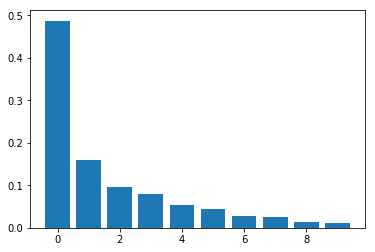

In [28]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_);

## Factor Betas
Implement `factor_betas` to get the factor betas from the PCA model.

In [29]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """
    Get the factor betas from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    factor_beta_indices : 1 dimensional Ndarray
        Factor beta indices
    factor_beta_columns : 1 dimensional Ndarray
        Factor beta columns

    Returns
    -------
    factor_betas : DataFrame
        Factor betas
    """
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1
    
    factor_betas = pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    return factor_betas

In [30]:
risk_model = {}
risk_model['factor_betas'] = factor_betas(pca, returns.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas']

,0,1,2,3,4,5,6,7,8,9
MMM,-0.175514,0.032154,-0.333659,0.013244,0.270848,-0.447322,-0.676642,0.264268,0.063120,0.227013
ABT,-0.171195,-0.037129,-0.154329,-0.023029,-0.052322,-0.209451,0.158017,-0.019571,-0.932993,0.050310
ABBV,-0.190976,0.050035,-0.551195,-0.040077,-0.766588,0.064066,-0.071727,-0.187380,0.147845,0.041549
ABMD,-0.523391,-0.722587,0.184036,0.369464,-0.034109,0.126884,-0.105994,-0.036173,0.038916,-0.047296
ACN,-0.152374,-0.008132,-0.193780,-0.077104,0.066229,-0.318088,0.162549,0.189334,0.106669,-0.868336
ATVI,-0.258549,-0.189704,0.110201,-0.902055,0.070356,0.185436,-0.150238,-0.095879,-0.010533,-0.010234
ADBE,-0.232475,-0.116564,-0.103772,-0.139687,0.038133,-0.344764,0.644498,0.328142,0.268728,0.431857
AMD,-0.676850,0.647653,0.319955,0.115208,-0.006653,0.072329,-0.008075,-0.027553,0.025986,-0.000255
AAP,-0.129448,0.062011,-0.540506,0.078603,0.391834,0.665444,0.117568,0.261779,-0.048459,-0.004970
AES,-0.102393,0.003386,-0.268679,0.050710,0.413176,-0.182627,0.150158,-0.819363,0.124261,0.036523


## Factor Returns
Implement `factor_returns` to get the factor returns from the PCA model using the returns data.

In [34]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """
    Get the factor returns from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    returns : DataFrame
        Returns for each ticker and date
    factor_return_indices : 1 dimensional Ndarray
        Factor return indices
    factor_return_columns : 1 dimensional Ndarray
        Factor return columns

    Returns
    -------
    factor_returns : DataFrame
        Factor returns
    """
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1
    
    factor_returns =pd.DataFrame(pca.transform(returns_5days), factor_return_indices, factor_return_columns)
    return factor_returns

20-Oct-19 02:24:33 DEBUG     update_title_pos
20-Oct-19 02:24:34 DEBUG     update_title_pos
20-Oct-19 02:24:34 DEBUG     update_title_pos
20-Oct-19 02:24:34 DEBUG     update_title_pos
20-Oct-19 02:24:34 DEBUG     update_title_pos


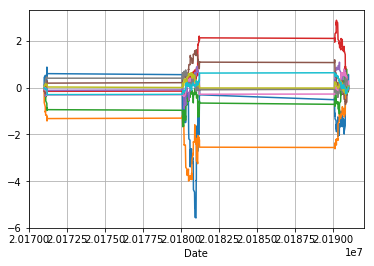

In [35]:
risk_model['factor_returns'] = factor_returns(
    pca,
    returns,
    returns.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot(legend=None,grid=True)

## Factor Covariance Matrix
Implement `factor_cov_matrix` to get the factor covariance matrix.

In [36]:
def factor_cov_matrix(factor_returns, ann_factor):
    """
    Get the factor covariance matrix

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns
    ann_factor : int
        Annualization factor

    Returns
    -------
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    """
    annualized_factor_covariance_matrix = np.diag(factor_returns.var(axis=0, ddof=1)*ann_factor)
    
    return annualized_factor_covariance_matrix

In [37]:
ann_factor = 252
risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor)

risk_model['factor_cov_matrix']

array([[2.98743219, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9755482 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.58381009, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.49159289, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.32555359,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.27400456, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.17386207, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

## Idiosyncratic Variance Matrix
Implement `idiosyncratic_var_matrix` to get the idiosyncratic variance matrix.

In [38]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    """
    Get the idiosyncratic variance matrix

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    factor_returns : DataFrame
        Factor returns
    factor_betas : DataFrame
        Factor betas
    ann_factor : int
        Annualization factor

    Returns
    -------
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    """
    
    common_returns_ = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    
    residuals_ = (returns - common_returns_)
    specific_risk_matrix = pd.DataFrame(np.diag(np.var(residuals_))*ann_factor, returns.columns, returns.columns)
    return specific_risk_matrix

In [39]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix']

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES
MMM,1.649775e-31,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
ABT,0.000000e+00,6.373027e-32,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
ABBV,0.000000e+00,0.000000e+00,2.455128e-31,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
ABMD,0.000000e+00,0.000000e+00,0.000000e+00,3.043872e-31,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
ACN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.225967e-31,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
ATVI,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.949355e-31,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
ADBE,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.398805e-31,0.000000e+00,0.000000e+00,0.000000e+00
AMD,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.124437e-31,0.000000e+00,0.000000e+00
AAP,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.261072e-31,0.000000e+00
AES,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.146736e-31


## Idiosyncratic Variance Vector
Implement `idiosyncratic_var_vector` to get the idiosyncratic variance Vector.

In [40]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    """
    Get the idiosyncratic variance vector

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix

    Returns
    -------
    idiosyncratic_var_vector : DataFrame
        Idiosyncratic variance Vector
    """

    idiosyncratic_var_vector = pd.DataFrame(np.diag(idiosyncratic_var_matrix),index=returns.columns)   
    return idiosyncratic_var_vector

In [41]:
risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(returns, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector']

,0
MMM,1.649775e-31
ABT,6.373027e-32
ABBV,2.455128e-31
ABMD,3.043872e-31
ACN,2.225967e-31
ATVI,2.949355e-31
ADBE,3.398805e-31
AMD,5.124437e-31
AAP,4.261072e-31
AES,3.146736e-31


## Predict using the Risk Model
Using the data we calculated in the risk model, implement `predict_portfolio_risk` to predict the portfolio risk using the formula $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

In [42]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    
    K = factor_betas.dot(factor_cov_matrix).dot(factor_betas.T) + idiosyncratic_var_matrix
    
    predicted_portfolio_risk = np.sqrt(weights.T.dot(K).dot(weights))    
    
    return predicted_portfolio_risk.values[0][0]

In [43]:
all_weights = pd.DataFrame(np.repeat(1/len(returns.columns), len(returns.columns)), returns.columns)

predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.4701591950194359

# Create Alpha Factors
With the profile risk calculated, it's time to start working on the alpha factors. In this project, we'll create the following factors:
- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Factor
- Overnight Sentiment Smoothed Factor

## Momentum 5day Factor
Each factor will have a hypothesis that goes with it. For this factor, it is "Higher past 12-month (252 days) returns are proportional to future return." Using that hypothesis, we've generated this code:

In [44]:
returns_demean_ranked = demean(returns).rank(axis=1)

In [45]:
returns_demean_zscore = zscore(returns_demean_ranked)

In [1]:
returns_demean_zscore.tail()

NameError: name 'returns_demean_zscore' is not defined

In [58]:
df

Returns5d                              Sector  \
Date     Symbol                                                  
20171027 MMM      0.057170                         Industrials   
         ABT     -0.017157                          Healthcare   
         ABBV    -0.045361                          Healthcare   
         ABMD     0.035622                          Healthcare   
         ACN      0.026452                         Industrials   
         ATVI     0.023542  Cyclical Consumer Goods & Services   
         ADBE     0.009530                          Technology   
         AMD     -0.166385                          Technology   
         AAP     -0.059197  Cyclical Consumer Goods & Services   
         AES     -0.032468                           Utilities   
20171030 MMM      0.040992                         Industrials   
         ABT     -0.032971                          Healthcare   
         ABBV    -0.039028                          Healthcare   
         ABMD     0.019389                          Healthcare   
         ACN      0.027636                         Industrials   
         ATVI     0.058806  Cyclical Consumer Goods & Services   
         ADBE     0.021985                          Technology   
         AMD     -0.294766                          Technology   
         AAP     -0.047683  Cyclical Consumer Goods & Services   
         AES     -0.036313                           Utilities   
20171031 MMM     -0.019375                         Industrials   
         ABT     -0.021206                          Healthcare   
         ABBV    -0.015956                          Healthcare   
         ABMD     0.084024                          Healthcare   
         ACN      0.024234                         Industrials   
         ATVI     0.042144  Cyclical Consumer Goods & Services   
         ADBE     0.020438                          Technology   
         AMD     -0.297223                          Technology   
         AAP     -0.030707  Cyclical Consumer Goods & Services   
         AES     -0.033866                           Utilities   
...                    ...                                 ...   
20191016 MMM      0.068997                         Industrials   
         ABT      0.027880                          Healthcare   
         ABBV     0.019398                          Healthcare   
         ABMD     0.108356                          Healthcare   
         ACN      0.011953                         Industrials   
         ATVI     0.038856  Cyclical Consumer Goods & Services   
         ADBE    -0.005757                          Technology   
         AMD      0.076274                          Technology   
         AAP      0.051244  Cyclical Consumer Goods & Services   
         AES      0.036578                           Utilities   
20191017 MMM      0.068668                         Industrials   
         ABT      0.027191                          Healthcare   
         ABBV     0.009183                          Healthcare   
         ABMD     0.080331                          Healthcare   
         ACN      0.011879                         Industrials   
         ATVI     0.034179  Cyclical Consumer Goods & Services   
         ADBE    -0.021319                          Technology   
         AMD      0.088632                          Technology   
         AAP      0.047634  Cyclical Consumer Goods & Services   
         AES      0.025862                           Utilities   
20191018 MMM      0.030656                         Industrials   
         ABT      0.038169                          Healthcare   
         ABBV     0.037013                          Healthcare   
         ABMD     0.032288                          Healthcare   
         ACN      0.011279                         Industrials   
         ATVI    -0.005134  Cyclical Consumer Goods & Services   
         ADBE    -0.048094                          Technology   
         AMD      0.039393                          Techn

# Disconnect

In [1]:
tws_conn.disconnect()

NameError: name 'tws_conn' is not defined